In [1]:
from course_helpers import load_dataset

df = load_dataset()

INFO:root:Loaded 1565 rows from https://ez-public.s3.amazonaws.com/comments.csv. First three records:


,content,is_spam
0,Best Music Ever!!!,0
1,please look up DHG SONGS this is my playlist with a bunch of amazing songs,1
2,just :( superr!!!,0


The MLflow server is not running.
Please run '/workspaces/mlops-course/start_mlflow_native.sh' in the Terminal.
Once MLflow is running, make sure you open http://localhost:5000/ in a browser.


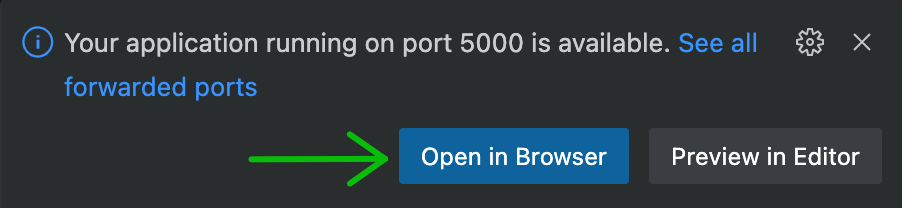

In [3]:
from course_helpers import mlflow_connect
my_experiment = mlflow_connect()

In [1]:
import mlflow

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer

# Initialize Random Forest model with best parameters
best_params = {"max_depth": None, "min_samples_split": 2, "n_estimators": 200}

X = df[["content"]]
y = df["is_spam"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

count_vectorizer = CountVectorizer()
rf = RandomForestClassifier(random_state=42, **best_params)

col_trans = ColumnTransformer(
    transformers=[
        (
            "text to features",
            count_vectorizer,
            "content",
        )  # Apply CountVectorizer directly to the 'text' column
    ],
    remainder="drop",
)

pipe = Pipeline([("Preprocess", col_trans), ("RandomForest", rf)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

accuracy = float(accuracy_score(y_test, y_pred))

mlflow.sklearn.autolog(disable=True)
with mlflow.start_run(run_name="Basic Spam Classification Model") as run:
    model_info = mlflow.sklearn.log_model(pipe, "spam_pipeline_model")

print(f"Accuracy of the Model: {accuracy}")

NameError: name 'df' is not defined

In [5]:
import pandas as pd

artifact_path = f"runs:/{run.info.run_id}/{model_info.artifact_path}"
print(f"Reloading model from {artifact_path}")
print()

content_df = pd.DataFrame(
    {
        "content": [
            "Click this link and subscribe to my channel!",
            "This is the best ever video about MLflow!",
        ]
    }
)

Reloading model from runs:/4d9f5db4501d4f3a909db8af1079e35b/spam_pipeline_model



In [6]:
reloaded_model = mlflow.sklearn.load_model(artifact_path)
predictions = pipe.predict(content_df)

pred_df = content_df.assign(prediction=predictions)
pred_df.head()

,content,prediction
0,Click this link and subscribe to my channel!,1
1,This is the best ever video about MLflow!,0


Logging with extra parameters

In [7]:
import datetime

mlflow.sklearn.autolog(disable=True)
with mlflow.start_run(run_name="Custom Spam Classification Model") as run:
    pip_requirements = [
        "scikit-learn==1.2.2",
        "mlflow==2.7",
    ]

    from mlflow.models import ModelSignature, infer_signature
    from mlflow.types.schema import Schema, ColSpec

    # Option 1: Manually construct the signature object
    input_schema = Schema(
        [
            ColSpec("string", "The content to be classified as spam or not spam"),
        ]
    )
    output_schema = Schema([ColSpec("double", "Content is spam (1) or not spam (0)")])
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)

    model_info = mlflow.sklearn.log_model(
        pipe,
        artifact_path="custom_spam_pipeline_model",
        input_example=content_df,
        pip_requirements=pip_requirements,
        signature=signature,
        metadata={
            "model_description": "Spam classifier trained on YouTube comments",
            "trained_at": datetime.datetime.utcnow().isoformat(),
            "accuracy": accuracy,
        },
    )

    print(f"Model logged with the ID: {model_info.model_uri} ")

Model logged with the ID: runs:/60aa4790cfbb4030a0eed3326dee4668/custom_spam_pipeline_model 
